In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from pandas_profiling import ProfileReport
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
plt.rcParams["figure.figsize"] = (12,7)
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('data/data_interview_test.csv',sep=":")

## Exploratory Data Analysis

In [12]:
df.shape

(12034, 14)

In [7]:
df.head(10)

,receipt_id,company_id,matched_transaction_id,feature_transaction_id,DateMappingMatch,AmountMappingMatch,DescriptionMatch,DifferentPredictedTime,TimeMappingMatch,PredictedNameMatch,ShortNameMatch,DifferentPredictedDate,PredictedAmountMatch,PredictedTimeCloseMatch
0,"10,000",10000,"10,468","10,000",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,"10,000",10000,"10,468","10,001",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,"10,000",10000,"10,468","10,003",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,"10,000",10000,"10,468","10,004",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,"10,000",10000,"10,468","10,005",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
5,"10,000",10000,"10,468","10,006",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
6,"10,000",10000,"10,468","10,008",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
7,"10,000",10000,"10,468","10,009",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
8,"10,000",10000,"10,468","10,010",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
9,"10,000",10000,"10,468","10,011",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [9]:
df.describe()

,company_id,DateMappingMatch,AmountMappingMatch,DescriptionMatch,DifferentPredictedTime,TimeMappingMatch,PredictedNameMatch,ShortNameMatch,DifferentPredictedDate,PredictedAmountMatch,PredictedTimeCloseMatch
count,12034.000000,12034.000000,12034.000000,12034.000000,12034.000000,12034.000000,12034.000000,12034.000000,12034.000000,12034.000000,12034.000000
mean,27247.797906,0.217901,0.031660,0.021522,0.986455,0.013877,0.024215,0.037893,0.753532,0.001005,0.076533
std,12024.542988,0.384535,0.122611,0.116995,0.115597,0.116987,0.128646,0.190945,0.430972,0.020134,0.265860
min,10000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20000.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,30000.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,30000.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,50000.000000,1.000000,0.900000,0.800000,1.000000,1.000000,0.800000,1.000000,1.000000,0.600000,1.000000


In [8]:
df.dtypes

receipt_id                  object
company_id                   int64
matched_transaction_id      object
feature_transaction_id      object
DateMappingMatch           float64
AmountMappingMatch         float64
DescriptionMatch           float64
DifferentPredictedTime     float64
TimeMappingMatch           float64
PredictedNameMatch         float64
ShortNameMatch             float64
DifferentPredictedDate     float64
PredictedAmountMatch       float64
PredictedTimeCloseMatch    float64
dtype: object

In [10]:
df.isna().sum()

receipt_id                 0
company_id                 0
matched_transaction_id     0
feature_transaction_id     0
DateMappingMatch           0
AmountMappingMatch         0
DescriptionMatch           0
DifferentPredictedTime     0
TimeMappingMatch           0
PredictedNameMatch         0
ShortNameMatch             0
DifferentPredictedDate     0
PredictedAmountMatch       0
PredictedTimeCloseMatch    0
dtype: int64

In [6]:
prof = ProfileReport(df)
prof.to_file(output_file='EDA.html')

Summarize dataset:   0%|          | 0/27 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

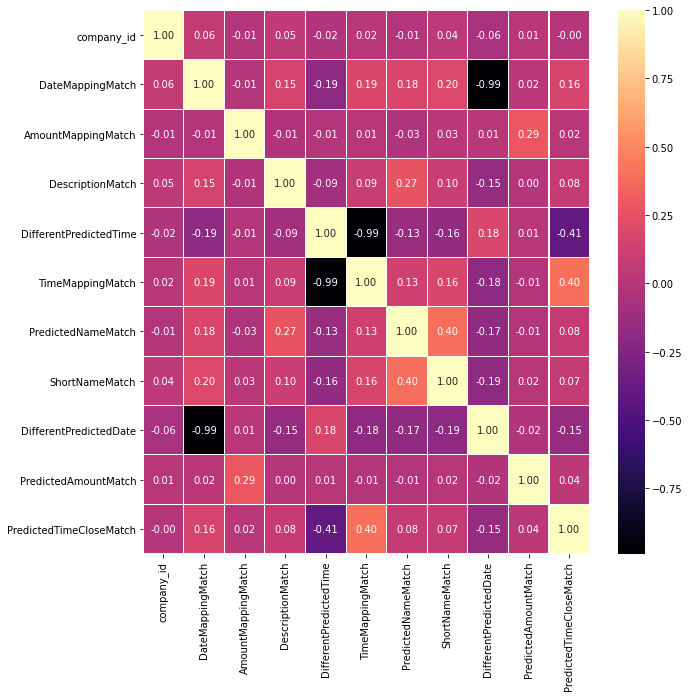

In [11]:
plt.figure(figsize=(10, 10))
sns.heatmap(df.corr(), annot=True, linewidths=0.05, fmt= '.2f',cmap="magma")
plt.show()

In [14]:
feature_columns = ['DateMappingMatch', 'AmountMappingMatch','DescriptionMatch', 'DifferentPredictedTime', 'TimeMappingMatch',
                   'PredictedNameMatch', 'ShortNameMatch', 'DifferentPredictedDate','PredictedAmountMatch', 'PredictedTimeCloseMatch']

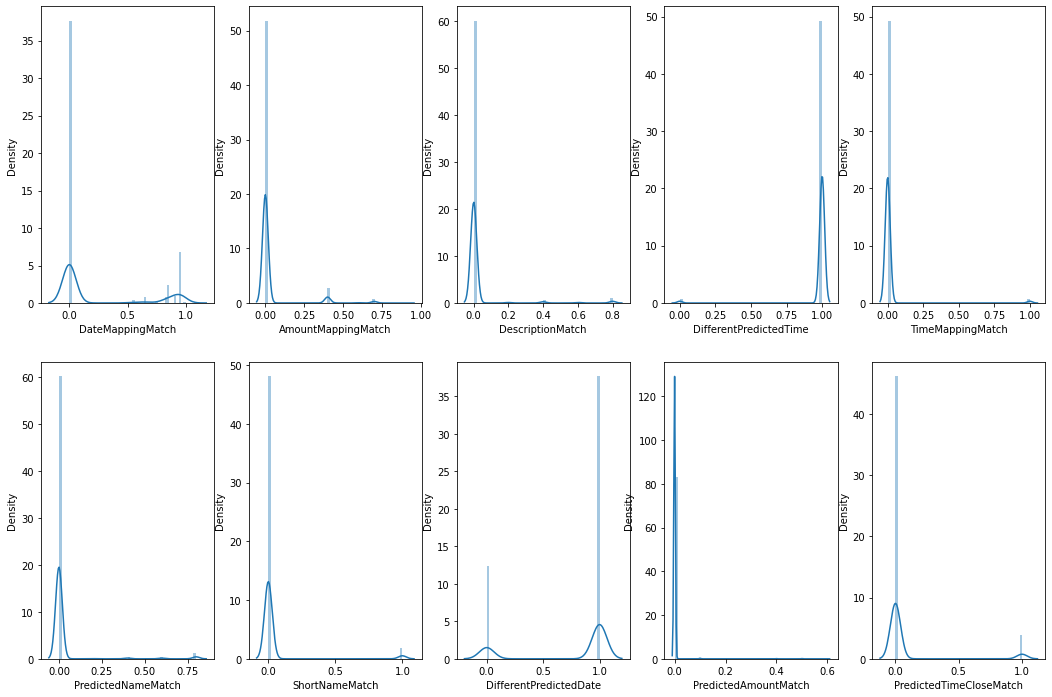

In [16]:
fig, axes = plt.subplots(2, 5,figsize=(18,12))

# unpack all the axes subplots
axe = axes.ravel()

# assign the plot to each subplot in axe
for i, c in enumerate(feature_columns):
    sns.distplot(df[c],ax=axe[i])
    
plt.show()

###  Insights

From the primary EDA , we can understand the following from the data

- Data contains 12034 rows with 1155 distinct receipts
- There are 4 Identifier columns and 10 feature columns in the data
- These are transactions from 5 different companies
- All the feature columns are either binary or float value ranging between 0,1
- The feature columns are values obtained by similarity matching at different levels of a transaction against an     original transaction
- There exists high negative correlation between these columns
    - DateMappingMatch --> DifferentPredictedDate
    - TimeMappingMatch --> DifferentPredictedTime

## Data Preparation

In [18]:
df.replace(',','', regex=True, inplace=True)

In [19]:
df[df['matched_transaction_id']=="10112"]

,receipt_id,company_id,matched_transaction_id,feature_transaction_id,DateMappingMatch,AmountMappingMatch,DescriptionMatch,DifferentPredictedTime,TimeMappingMatch,PredictedNameMatch,ShortNameMatch,DifferentPredictedDate,PredictedAmountMatch,PredictedTimeCloseMatch
264,10021,10000,10112,10108,0.00,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
265,10021,10000,10112,10109,0.00,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
266,10021,10000,10112,10110,0.00,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
267,10021,10000,10112,10112,0.95,0.0,0.0,1.0,0.0,0.6,0.0,0.0,0.0,0.0
268,10021,10000,10112,10113,0.95,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
269,10021,10000,10112,10114,0.95,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


Here we have an example of one receipt where the real transaction id is "10112" in matched_transaction_id columns
and all the transactions which got matched against it are in feature_transaction_id column. 

Here row 267 is the Correct match for transaction 10112 since matched_transaction_id and feature_transaction_id is
same [as per problem statement]

So using this idea , we can create a Target column which gives us idea about which transactions are the original matching transaction for a matched_transaction_id

In [20]:
df['CorrectMatch'] = np.where(df['matched_transaction_id']==df['feature_transaction_id'],1,0)

In [22]:
df['CorrectMatch'].value_counts()

0    11177
1      857
Name: CorrectMatch, dtype: int64

Out of 1155 transaction , we know the original transaction for 857 of them

We can make a subset out of our existing dataframe to get the transactions which have an original transaction in the given scenario which gets some noisy data out